In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import spacy
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Further data Cleaning
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize words
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stem words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

In [ ]:
# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Suicide/Suicide_Detection.csv')

In [ ]:
# Preprocess text (remove punctuation, lowercase, tokenize, etc.)
data["preprocessed_text"] = data["text"].apply(preprocess_text)

In [ ]:
data.head()

,Unnamed: 0,text,class,preprocessed_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,"[ex, wife, threaten, suiciderec, left, wife, g..."
1,3,Am I weird I don't get affected by compliments...,non-suicide,"[weird, dont, get, affect, compliment, come, s..."
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,"[final, almost, never, hear, bad, year, ever, ..."
3,8,i need helpjust help me im crying so hard,suicide,"[need, helpjust, help, im, cri, hard]"
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"[im, losthello, name, adam, ive, struggl, year..."


In [ ]:
#Word Embeddings

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=data["preprocessed_text"], vector_size=100, window=5, min_count=1, sg=0)
# Assuming "preprocessed_text" column contains lists of tokens
X_word_embeddings = []
# Generate word vectors for speech segments
speech_vectors = []
for segment_text in data["preprocessed_text"]:
    word_vectors = [word2vec_model.wv[word] for word in segment_text if word in word2vec_model.wv]
    avg_vector = sum(word_vectors) / len(word_vectors) if word_vectors else [0.0] * 100
    speech_vectors.append(avg_vector)

# Obtain word embeddings and aggregate sentence embeddings
for tokens in data["preprocessed_text"]:
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        sentence_embedding = sum(embeddings) / len(embeddings)
    else:
        sentence_embedding = [0.0] * word2vec_model.vector_size
    X_word_embeddings.append(sentence_embedding)

# Convert the list of embeddings to a NumPy array
X_word_embeddings = np.array(X_word_embeddings)

In [ ]:
# TF-IDF Vectorization with N-grams
tfidf_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(data["text"]).toarray()

In [ ]:
# Word2Vec Variants
X_word2vec = []
for tokens in data["text"]:
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        sentence_embedding = sum(embeddings) / len(embeddings)
    else:
        sentence_embedding = [0.0] * word2vec_model.vector_size
    X_word2vec.append(sentence_embedding)

In [ ]:
# Word Frequency and Document Length
word_frequency = [text.count("Label") for text in data["text"]]  # Replace "target_word"
doc_lengths = [len(text.split()) for text in data["text"]]
X_word_freq_doc_len = np.column_stack((word_frequency, doc_lengths))

In [ ]:
#Functions for all linguistic features
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Calculate Type Token Ratio (TTR) using preprocessed word lists
data['ttr'] = data['text'].apply(lambda x: len(set(x)) / len(x))

vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(data['text'])
total_words = X.sum(axis=1)
unique_words = (X > 0).sum(axis=1)
data['ttr'] = unique_words / total_words
def calculate_prepositional_ratio(text):
    doc = nlp(" ".join(text))
    total_words = len(doc)

    if total_words == 0:
        return 0.0

    num_prepositions = sum(1 for token in doc if token.pos_ == "ADP")
    prepositional_ratio = num_prepositions / total_words
    return prepositional_ratio

def calculate_verb_to_noun_ratio(text):
    doc = nlp(" ".join(text))
    total_words = len(doc)

    if total_words == 0:
        return 0.0

    num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
    num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")

    if num_nouns == 0:
        return 0.0

    verb_to_noun_ratio = num_verbs / num_nouns
    return verb_to_noun_ratio

def calculate_content_density(text):
    doc = nlp(" ".join(text))
    total_words = len(doc)

    if total_words == 0:
        return 0.0

    num_content_words = sum(1 for token in doc if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"])
    content_density = num_content_words / total_words
    return content_density

data['prepositional_ratio'] = data['preprocessed_text'].apply(calculate_prepositional_ratio)
data['verb_to_noun_ratio'] = data['preprocessed_text'].apply(calculate_verb_to_noun_ratio)
data['content_density'] = data['preprocessed_text'].apply(calculate_content_density)


# Calculate noun ratio and verb ratio
def calculate_pos_ratios(text):
    doc = nlp(" ".join(text))  # Join the list of preprocessed words into a single string
    total_words = len(doc)

    if total_words == 0:
        return 0.0, 0.0  # Return 0.0 for both ratios if there are no words

    num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")
    num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
    noun_ratio = num_nouns / total_words
    verb_ratio = num_verbs / total_words
    return noun_ratio, verb_ratio

data['noun_ratio'], data['verb_ratio'] = zip(*data['preprocessed_text'].apply(calculate_pos_ratios))

# Combine the results into the DataFrame
X_linguistic_features = data[['ttr', 'noun_ratio', 'verb_ratio', 'prepositional_ratio', 'content_density','verb_to_noun_ratio']].values

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Combine features
X_combined = np.concatenate((
    X_word_embeddings,
    #X_sentence_embeddings,
    X_tfidf,

    X_word2vec,
    #X_glove,
    X_word_freq_doc_len,
    #X_hesitation,
    #X_linguistic_features
), axis=1)

In [ ]:
X_combined

array([[-6.69721738e-02, -1.02083474e-01, -3.73419285e-01, ...,
        -2.29772970e-01,  0.00000000e+00,  1.43000000e+02],
       [-5.18011451e-01, -2.28436396e-01, -3.14218283e-01, ...,
        -2.79742092e-01,  0.00000000e+00,  2.70000000e+01],
       [-6.64271653e-01, -1.40818357e-01, -5.10957301e-01, ...,
        -2.88859576e-01,  0.00000000e+00,  2.60000000e+01],
       ...,
       [-2.18305230e-01, -1.87229395e-01, -3.28340270e-02, ...,
        -1.66969150e-01,  0.00000000e+00,  1.40000000e+01],
       [-3.66344362e-01, -7.45199993e-02, -2.45906174e-01, ...,
        -2.26519227e-01,  0.00000000e+00,  3.64000000e+02],
       [-3.45103443e-01, -1.80875257e-01, -4.22301590e-01, ...,
        -3.54549468e-01,  0.00000000e+00,  3.30000000e+01]])

In [ ]:
# Assuming your data is in a pandas DataFrame named 'data'
# Create a dictionary to map string labels to numerical values
label_mapping = {"suicide": 1, "non-suicide": 0}

# Apply the mapping to the "class" column (assuming it's a string column)
data["class"] = data["class"].replace(label_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, data["class"], test_size=0.2, shuffle=True, random_state=42
)

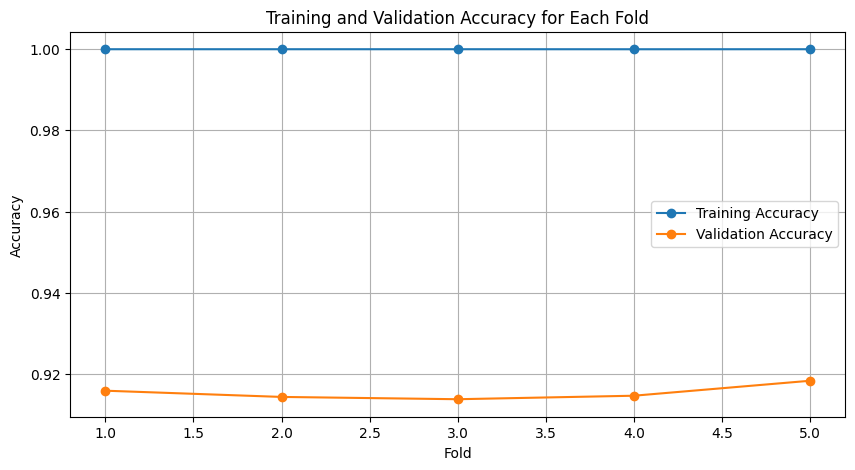

Cross-validated training accuracy scores: [1.         1.         1.         0.99999327 1.        ]
Mean training accuracy: 0.9999986534434816
Cross-validated validation accuracy scores: [0.91584078 0.91430572 0.91374017 0.91460196 0.9182893 ]
Mean validation accuracy: 0.9153555870370573


In [ ]:
# Convert the data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Create the Random Forest Classifier with desired parameters
classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Initialize lists to store training and validation accuracy for each fold
train_scores = []
validation_scores = []

# Number of folds for cross-validation
num_folds = 5

# Create the StratifiedKFold object for cross-validation
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the classifier on the training fold
    classifier.fit(X_train_fold, y_train_fold)

    # Calculate training accuracy
    y_train_pred = classifier.predict(X_train_fold)
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    train_scores.append(train_accuracy)

    # Calculate validation accuracy
    y_val_pred = classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    validation_scores.append(val_accuracy)

# Convert lists to numpy arrays for easy manipulation
train_scores = np.array(train_scores)
validation_scores = np.array(validation_scores)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_folds + 1), train_scores, label='Training Accuracy', marker='o')
plt.plot(range(1, num_folds + 1), validation_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Print the accuracy scores for each fold
print("Cross-validated training accuracy scores:", train_scores)
print("Mean training accuracy:", train_scores.mean())
print("Cross-validated validation accuracy scores:", validation_scores)
print("Mean validation accuracy:", validation_scores.mean())

# Fit the classifier on the entire training set
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)


In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9155660885489605
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     23287
           1       0.92      0.91      0.91     23128

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Create the Random Forest Classifier with desired parameters
classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform cross-validation
num_folds = 5  # Number of folds for cross-validation
scoring = make_scorer(accuracy_score)  # Scoring metric

# Use cross_val_score to compute cross-validated accuracy scores
cv_scores = cross_val_score(classifier, X_train, y_train, cv=num_folds, scoring=scoring)

# Print the accuracy scores for each fold
print("Cross-validated accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Fit the classifier on the entire training set
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Cross-validated accuracy scores: [0.91392869 0.91689109 0.91379403 0.91570613 0.91694272]
Mean accuracy: 0.9154525312006697


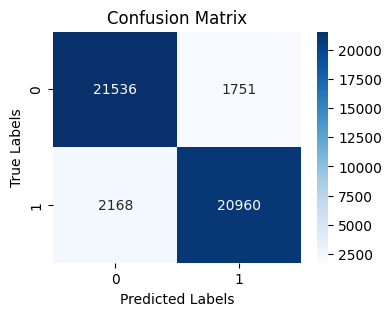

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classifier.classes_,
            yticklabels=classifier.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

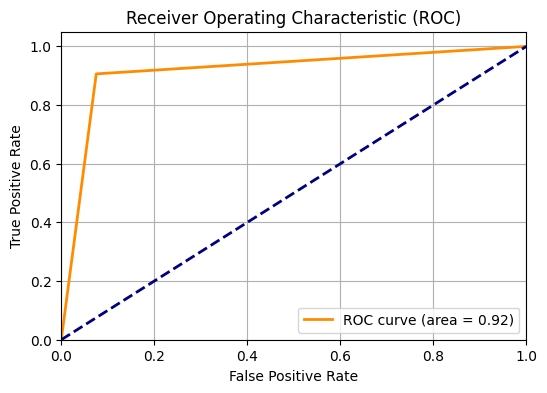

In [ ]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Add grid lines
plt.grid()



plt.show()